In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'none'

# seaborn package for making pretty plots, but not necessary
try:
    import seaborn as sns
    params =   {'xtick.direction': 'in', 'ytick.direction': 'in', 'font.family': ['serif'],
                'text.usetex': True, 'text.latex.preamble': ['\usepackage{gensymb}']}
    sns.set_style("ticks", params)
except ImportError:
    print('Seaborn module is not installed.')
    
from IPython.display import display, Latex

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import (webbpsf, poppy, pix_noise)

from pynrc import speckle_noise as sn

import astropy.io.fits as fits
import multiprocessing as mp

In [3]:
pynrc.setup_logging('WARNING', verbose=False)

In [4]:
data_path = webbpsf.utils.get_webbpsf_data_path() + '/'
opd_path = data_path + 'NIRCam/OPD/'
opd_file = 'OPD_RevV_nircam_132.fits'
opds, header = fits.getdata(opd_path + opd_file, header=True)

In [5]:
nopd = opds.shape[0]
nproc = int(np.min([nopd,mp.cpu_count()*0.75]))

In [6]:
# Multiprocessing or each OPD
%time opds_all = sn.opd_extract_mp(opds, header)

Finished.
Finished.
Finished.
Finished.
Finished.
Finished.
Finished.
Finished.
Finished.
Finished.
CPU times: user 1.65 s, sys: 3.55 s, total: 5.21 s
Wall time: 53.1 s


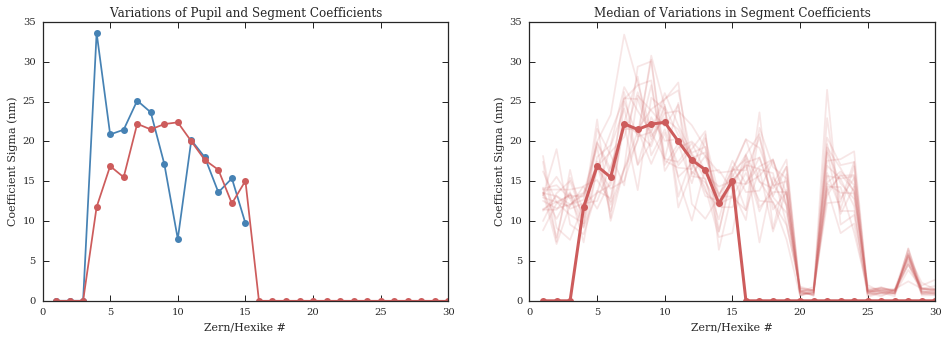

In [7]:
# For the pupil OPD and each segment OPD, find the stdev of each Zern/Hexike coefficient
pup_cf_std = np.array([opds_all[i].coeff_pupil for i in range(9)]).std(axis=0)

nseg = 18
seg_cf_std_all = []
for j in range(nseg):
    std = np.array([opds_all[i].coeff_segs[j] for i in range(9)]).std(axis=0)
    seg_cf_std_all.append(std)
seg_cf_std = np.median(seg_cf_std_all, axis=0)

# These values will be used to vary RMS WFE
# Set the piston values (Z1) to 0
# John Krist also says tip/tilt (Z2-3) are 0
pup_cf_std[0:3] = 0.0
seg_cf_std[0:3] = 0.0

# Zern/Hexikes to vary: Z = 3-14 (indices 3-7)
pup_cf_std[15:] = 0
seg_cf_std[15:] = 0

znum_pup = np.arange(len(pup_cf_std))+1
znum_seg = np.arange(len(seg_cf_std))+1

f, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.plot(znum_pup, pup_cf_std*1000, color='steelblue', marker='o')
ax1.plot(znum_seg, seg_cf_std*1000, color='indianred', marker='o')
ax1.set_title('Variations of Pupil and Segment Coefficients')
ax2.set_title('Median of Variations in Segment Coefficients')

for seg in seg_cf_std_all: 
    ax2.plot(znum_seg, seg*1000, color='indianred', alpha=0.15)
ax2.plot(znum_seg, seg_cf_std*1000, color='indianred', marker='o', lw=3)

for ax in (ax1,ax2):
    ax.set_xlabel('Zern/Hexike #')
    ax.set_ylabel('Coefficient Sigma (nm)')

## Science and Reference OPDs

In [8]:
# Generate list of science OPDs and residuals for use in reference drift.
%time opd_sci_list, opd_resid_list = sn.opd_sci_gen_mp(opds_all)

CPU times: user 2.38 s, sys: 3.74 s, total: 6.13 s
Wall time: 12.7 s


In [9]:
# For a series of WFE drift values:
#   - Generate a new set of OPDs
#   - Generate a new set of reference PSFs
#   - Calculate the contrast
drift_list = [1.0,10.0] #[1.0,5.0,10.0,20.0]
args = (opds_all, pup_cf_std, seg_cf_std, opd_resid_list) # Arguments to pass

# OPDs for all four drift values (10x4)
%time opd_ref_list_all = [sn.ODP_drift_all(wfe_drift, *args) for wfe_drift in drift_list]

Finished: 1 nm
Finished: 10 nm
CPU times: user 5.1 s, sys: 8.57 s, total: 13.7 s
Wall time: 34.8 s


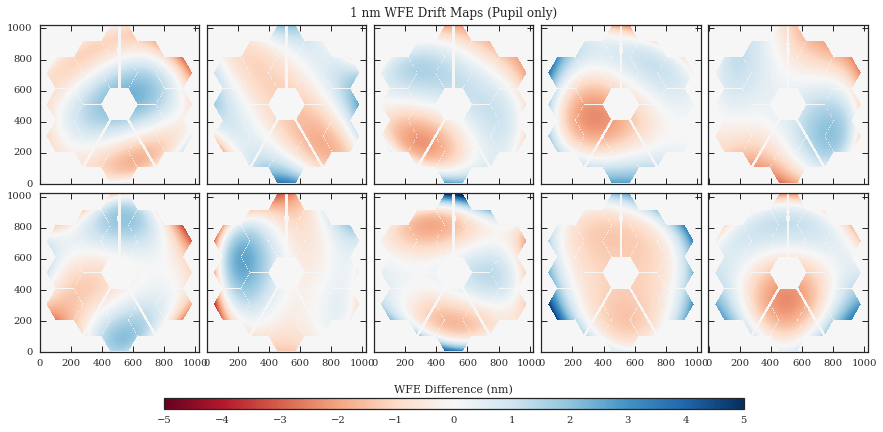

In [10]:
fig, axes = plt.subplots(2,5,figsize=(11.5,6))

ind = 0
vlim = 5 * drift_list[ind]
opd_ref_list = opd_ref_list_all[ind]
for i,ax in enumerate(axes.flat):
    im = ax.imshow((opd_sci_list[i]-opd_ref_list[i])*1000, cmap='RdBu', vmin=-vlim, vmax=vlim)
    ax.set_aspect('equal')
    if i % 5 > 0: ax.set_yticklabels([])
    if i < 5: ax.set_xticklabels([])

#fig.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.05, top=0.94, bottom=0.18, left=0, right=1)

cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.025])
fig.colorbar(im, cax=cbar_ax, orientation = 'horizontal')
cbar_ax.set_xlabel('WFE Difference (nm)')
cbar_ax.xaxis.set_label_position('top');

fig.suptitle('{:.0f} nm WFE Drift Maps (Pupil only)'.format(drift_list[ind]));
#outdir = '/Users/jwstnircam/Desktop/NRC_Coronagraph/WFE_models/'
#fig.savefig(outdir+'wfe_diff_10nm_lebreton.pdf')

# Speckle Noise Maps

In [11]:
# Common codeblock to use for various filter and pupil settings
# Assume all variables are set globally before calling the codeblock
import os
def codeblock():
    ndrift = len(drift_list)
    ext = 1 # Detector sampled extension
    keys_all = ['OVERSAMP','DET_SAMP','PIXELSCL','FOV', 'INSTRUME','FILTER','MODULE','CHANNEL',
                'OFFSET','THETA','XOFFSET','YOFFSET','PUPILINT','PUPILOPD','DATE','AUTHOR']
    
    for filt in filt_all:
        file_out = outdir+filt+'_speckle_noise_1nm.fits'
        file_out2 = outdir+filt+'_residual_speckles_1nm.fits'
        if os.path.exists(file_out) and os.path.exists(file_out2):
            print('Skipping filter {} since files already exist.'.format(filt))
            continue
        
        print('Filter: ' + filt)
        print('  Generating stellar PSFs...')
        psf_star = [sn.get_psf(opd, header, filt, mask, pupil) for opd in opd_sci_list]
        
        if not os.path.exists(file_out2):
            print('  Generating reference PSFs (1nm drift only)..')
            psf_ref  = [sn.get_psf(opd, header, filt, mask, pupil) for opd in opd_ref_list_all[0]]
            print('  Creating residual speckle images (1nm drift only)...')
            diff0_1nm, diff1_1nm = sn.residual_speckle_image(psf_star, psf_ref)

            # Save FITS file
            hdu = fits.PrimaryHDU(diff1_1nm)
            hdu.header['WFEDRIFT'] = (1.0, 'Wavefront error drift in nm performed on OPD')
            # Copy a bunch of keys to new header
            hdr_orig = psf_ref[0][ext].header
            for key in keys_all: hdu.header[key] = (hdr_orig[key], hdr_orig.comments[key])
            hdu.writeto(file_out2, clobber=True)

        if os.path.exists(file_out):
            continue
            
        # Planet PSFs are used for getting contrast curves
        #if mask is None:
        #    psf_planet = psf_star[0] # Planet and star PSFs are the same
        #else:
        #    psf_planet = sn.get_psf(opd_sci_list[0], header, filt, None, pupil)
            
        # Get all reference PSFs
        # This includes the multiple drift values
        print('  Generating reference PSFs for speckle noise maps...')
        psf_ref_all = sn.gen_psf_ref_all(opd_ref_list_all, header, filt, mask, pupil)

        # Create a series of speckle noise images for each drift amount
        print('  Creating speckle noise maps...')
        speckle_map = [sn.speckle_noise_image(psf_star, psf_ref) for psf_ref in psf_ref_all]

        # Get the noise ratio relative to 1 nm drift
        print('  Combining speckle maps and saving to disk...')
        ratio = [np.median(speckle_map[i][ext].data / speckle_map[0][ext].data) for i in range(ndrift)]

        # Scale everything to 1nm drift and average
        speckle_scaled = []
        for i in range(ndrift):
            im = speckle_map[i][ext].data / ratio[i]
            speckle_scaled.append(im)
        speckle_master = np.mean(np.array(speckle_scaled), axis=0, dtype='float32')
        
        # Save FITS file
        hdu = fits.PrimaryHDU(speckle_master)
        hdu.header['WFEDRIFT'] = (1.0, 'Wavefront error drift in nm performed on OPD')
        # Copy a bunch of keys to new header
        hdr_orig = speckle_map[0][ext].header
        for key in keys_all: hdu.header[key] = (hdr_orig[key], hdr_orig.comments[key])
        hdu.writeto(file_out, clobber=True)


## Direct Imaging Speckle Maps

In [12]:
filt_wide_sw = ['F070W', 'F090W', 'F115W', 'F150W', 'F150W2', 'F200W']
filt_wide_lw = ['F277W', 'F322W2', 'F356W', 'F444W']

filt_med_sw = ['F140M', 'F162M', 'F182M', 'F210M']
filt_med_lw = ['F250M', 'F300M', 'F335M', 'F360M', 'F410M', 'F430M', 'F460M', 'F480M']

filt_narr_sw = ['F164N', 'F187N', 'F212N']
filt_narr_lw = ['F323N', 'F405N', 'F466N', 'F470N']

filt_all_sw = filt_wide_sw + filt_med_sw + filt_narr_sw
filt_all_lw = filt_wide_lw + filt_med_lw + filt_narr_lw
filt_all = filt_all_sw + filt_all_lw

mask = None
pupil = None

outdir = pynrc.conf.PYNRC_PATH + 'speckle_maps/direct/'

codeblock()

Skipping filter since files already exist.
Skipping filter since files already exist.
Skipping filter since files already exist.
Skipping filter since files already exist.
Skipping filter since files already exist.
Skipping filter since files already exist.
Skipping filter since files already exist.
Skipping filter since files already exist.
Skipping filter since files already exist.
Skipping filter since files already exist.
Skipping filter since files already exist.
Skipping filter since files already exist.
Skipping filter since files already exist.
Skipping filter since files already exist.
Skipping filter since files already exist.
Skipping filter since files already exist.
Skipping filter since files already exist.
Skipping filter since files already exist.
Skipping filter since files already exist.
Skipping filter since files already exist.
Skipping filter since files already exist.
Skipping filter since files already exist.
Skipping filter since files already exist.
Skipping fi

## MASK430R Speckle Maps

In [13]:
filt_all = filt_med_lw + filt_wide_lw
mask = 'MASK430R'
pupil = 'CIRCLYOT'

outdir = pynrc.conf.PYNRC_PATH + 'speckle_maps/'+mask+'/'

codeblock()

Filter: F250M
  Generating stellar PSFs...
  Generating reference PSFs (1nm drift only)..
  Creating residual speckle images (1nm drift only)...
  Generating reference PSFs for speckle noise maps...
  Creating speckle noise maps...
  Combining speckle maps and saving to disk...
Filter: F300M
  Generating stellar PSFs...
  Generating reference PSFs (1nm drift only)..
  Creating residual speckle images (1nm drift only)...
Filter: F335M
  Generating stellar PSFs...
  Generating reference PSFs (1nm drift only)..
  Creating residual speckle images (1nm drift only)...
Filter: F360M
  Generating stellar PSFs...
  Generating reference PSFs (1nm drift only)..
  Creating residual speckle images (1nm drift only)...
  Generating reference PSFs for speckle noise maps...
  Creating speckle noise maps...
  Combining speckle maps and saving to disk...
Skipping filter since files already exist.
Skipping filter since files already exist.
Filter: F460M
  Generating stellar PSFs...
  Generating reference 

## MASK335R Speckle Maps

In [14]:
filt_all = filt_med_lw + filt_wide_lw + filt_med_sw + filt_wide_sw
#filt_all = ['F150W2', 'F250M','F300M', 'F335M', 'F360M', 'F410M', 'F430M', 'F356W', 'F444W']
mask = 'MASK335R'
pupil = 'CIRCLYOT'

outdir = pynrc.conf.PYNRC_PATH + 'speckle_maps/'+mask+'/'

codeblock()

Skipping filter since files already exist.
Skipping filter since files already exist.
Skipping filter since files already exist.
Skipping filter since files already exist.
Skipping filter since files already exist.
Skipping filter since files already exist.
Filter: F460M
  Generating stellar PSFs...
  Generating reference PSFs (1nm drift only)..
  Creating residual speckle images (1nm drift only)...
  Generating reference PSFs for speckle noise maps...
  Creating speckle noise maps...
  Combining speckle maps and saving to disk...
Filter: F480M
  Generating stellar PSFs...
  Generating reference PSFs (1nm drift only)..
  Creating residual speckle images (1nm drift only)...
  Generating reference PSFs for speckle noise maps...
  Creating speckle noise maps...
  Combining speckle maps and saving to disk...
Filter: F277W
  Generating stellar PSFs...
  Generating reference PSFs (1nm drift only)..
  Creating residual speckle images (1nm drift only)...
  Generating reference PSFs for speckle

## MASK210R Speckle Maps

In [16]:
filt_all = filt_med_sw + filt_wide_sw
mask = 'MASK210R'
pupil = 'CIRCLYOT'

outdir = pynrc.conf.PYNRC_PATH + 'speckle_maps/'+mask+'/'

codeblock()

Skipping filter since files already exist.
Filter: F140M
  Generating stellar PSFs...
  Generating reference PSFs...
  Creating residual speckle images...
Filter: F162M
  Generating stellar PSFs...
  Generating reference PSFs...
  Creating residual speckle images...
Filter: F182M
  Generating stellar PSFs...
  Generating reference PSFs...
  Creating residual speckle images...
Skipping filter since files already exist.
Filter: F150W
  Generating stellar PSFs...
  Generating reference PSFs...
  Creating residual speckle images...
  Generating reference PSFs...
  Creating speckle noise maps...
  Combining speckle maps and saving to disk...
Filter: F200W
  Generating stellar PSFs...
  Generating reference PSFs...
  Creating residual speckle images...
  Generating reference PSFs...
  Creating speckle noise maps...
  Combining speckle maps and saving to disk...
